In [1]:
import os
from datasets.coco_dataset import CocoDataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import random
import numpy as np
import matplotlib.pyplot as plt
from augmentations.transforms import get_augmentation
from configs import Config

In [2]:
config = Config('./configs/vinai512.yaml')

In [3]:
transforms = get_augmentation(config, _type='train')

In [4]:
dataset = CocoDataset(
    config=config,
    root_dir = os.path.join('datasets', config.project_name, config.train_imgs),
    ann_path = os.path.join('datasets', config.project_name, config.train_anns),
    transforms = transforms,
    train=True
)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


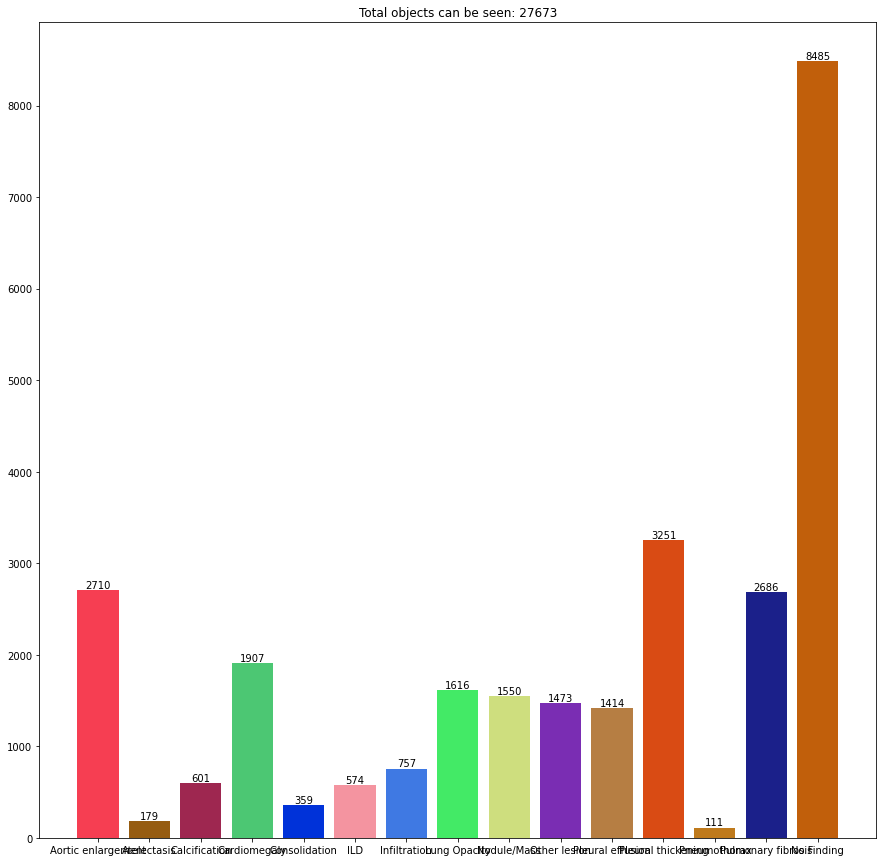

In [7]:
%matplotlib inline
dataset.plot(figsize=(15,15))

In [9]:
dataset[0]

{'img': tensor([[[0.0455, 0.0439, 0.0445,  ..., 0.0000, 0.0000, 0.0000],
          [0.0405, 0.0390, 0.0379,  ..., 0.0000, 0.0000, 0.0000],
          [0.0343, 0.0330, 0.0327,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5412, 0.5409, 0.5430],
          [0.0000, 0.0000, 0.0000,  ..., 0.5439, 0.5405, 0.5336],
          [0.0000, 0.0000, 0.0000,  ..., 0.5451, 0.5422, 0.5344]],
 
         [[0.0455, 0.0439, 0.0445,  ..., 0.0000, 0.0000, 0.0000],
          [0.0405, 0.0390, 0.0379,  ..., 0.0000, 0.0000, 0.0000],
          [0.0343, 0.0330, 0.0327,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5412, 0.5409, 0.5430],
          [0.0000, 0.0000, 0.0000,  ..., 0.5439, 0.5405, 0.5336],
          [0.0000, 0.0000, 0.0000,  ..., 0.5451, 0.5422, 0.5344]],
 
         [[0.0455, 0.0439, 0.0445,  ..., 0.0000, 0.0000, 0.0000],
          [0.0405, 0.0390, 0.0379,  ..., 0.0000, 0.0000, 0.0000],
          [0.0343, 0.0330, 0.0327

IndexError: too many indices for array

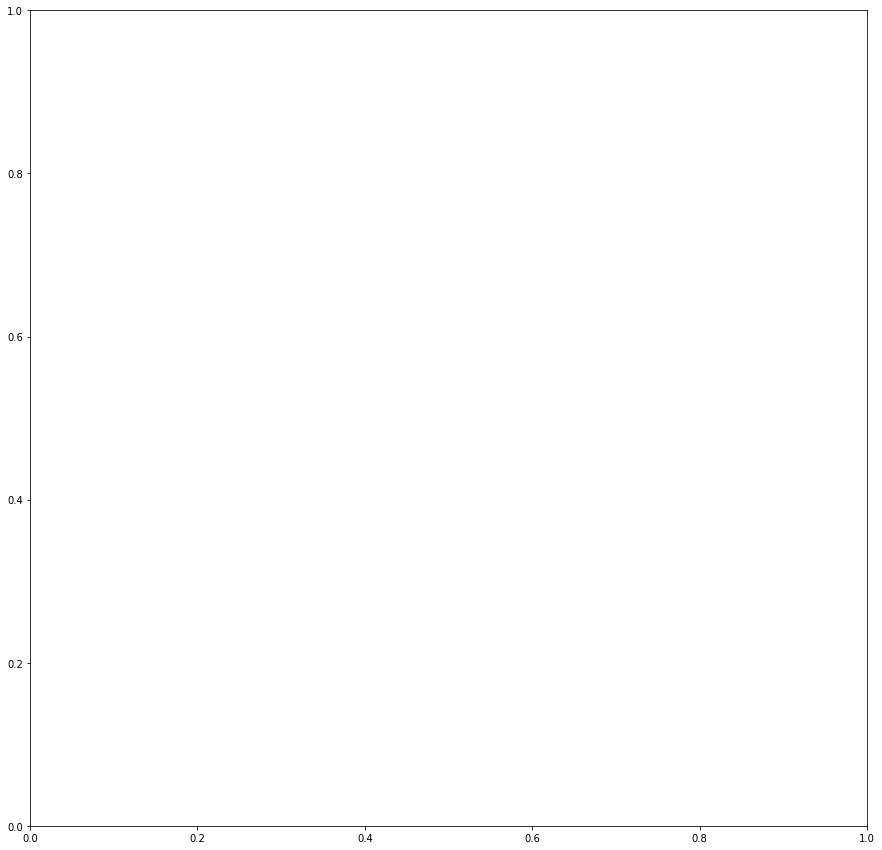

In [8]:
%matplotlib inline
dataset.visualize_item()